In [1]:
import torch
import faces_model
from PIL import Image
import data
import torchvision.transforms as transforms
from torch.autograd import Variable
from net_sphere import sphere20a
from open_face_model import OpenFace
import matplotlib.pyplot as plt

import torchvision

import torch.nn as nn

from DTNet.datasets import celebA
from data_utils import *

In [2]:
class ZeroPadBottom(object):
    ''' Zero pads batch of image tensor Variables on bottom to given size. Input (B, C, H, W) - padded on H axis. '''
    def __init__(self, size, use_gpu=True):
        self.size = size
        self.use_gpu = use_gpu
        
    def __call__(self, sample):
        B, C, H, W = sample.size()
        diff = self.size - H
        padding = Variable(torch.zeros(B, C, diff, W), requires_grad=False)
        if self.use_gpu:
            padding = padding.cuda()
        zero_padded = torch.cat((sample, padding), dim=2)
        return zero_padded

In [3]:
f_model = sphere20a(feature=True)
f_model.load_state_dict(torch.load('./pretrained_model/sphere20a_20171020.pth'))
for param in f_model.parameters():
    param.requires_grad = False
f_model = f_model.cuda()

In [5]:
model = torch.load('./log/fin_model.tar')
image = Image.open('../data/celebA/images/000001.jpg')

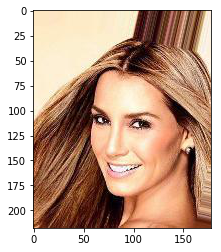

torch.Size([1, 3, 112, 96])

In [6]:
plt.imshow(image)
plt.show()
img = image.convert('RGB')
toPIL = transforms.ToPILImage()
toTensor = transforms.ToTensor()
pad112 = ZeroPadBottom(112)
msface_transform = transforms.Compose(
                [data.ResizeTransform(96), data.NormalizeRangeTanh()])
image = msface_transform(img)
    #plt.imshow(np.transpose(image, (1, 2, 0)))
image = toTensor(toPIL(image))
image = image.unsqueeze(0)
image = Variable(image.float().cuda())
image = pad112(image)
image.size()

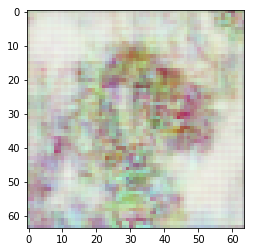

In [7]:
s_f = f_model(image)
g_model = model['G_model']
out = g_model(s_f)
a = out.detach()
a = a.cpu().data
a = (a + 1.0) * 0.5
npimg_ms = a[0]
zero_array = np.zeros(npimg_ms.shape)
one_array = np.ones(npimg_ms.shape)

npimg_ms = np.minimum(npimg_ms,one_array)
npimg_ms = np.maximum(npimg_ms,zero_array)

   # plt.imshow(np.transpose(npimg_ms, (1, 2, 0))) 
   # plt.show()
result = np.transpose(a[0], (1,2,0))
    # a = np.expand_dims(a, axis=0) 
plt.imshow(result)

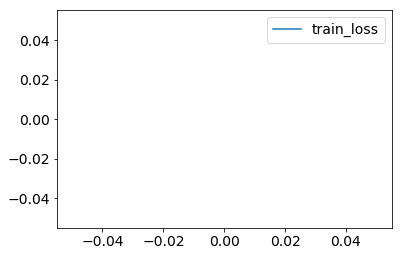

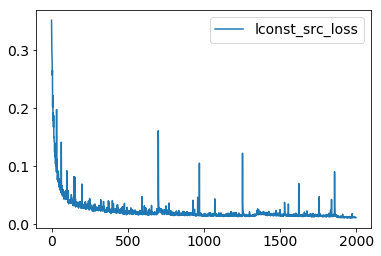

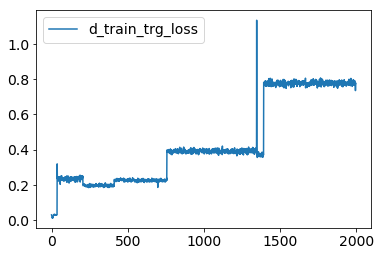

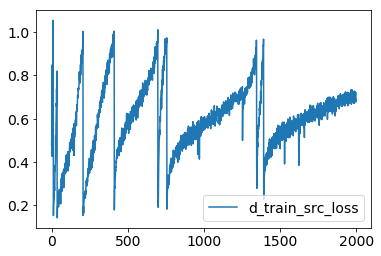

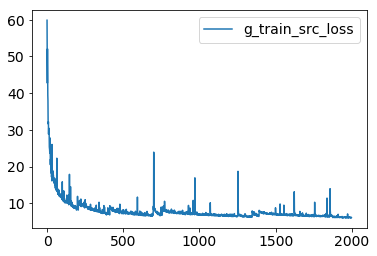

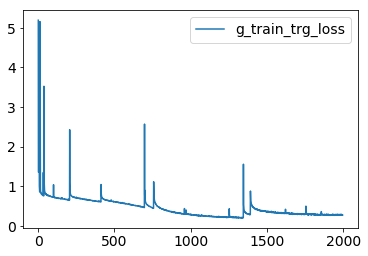

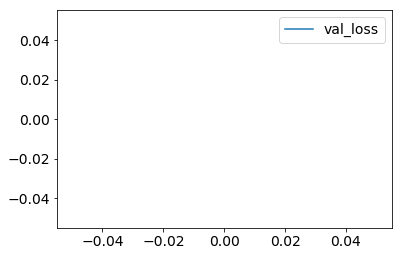

In [8]:
import matplotlib
plt.figure()
matplotlib.rcParams['font.size'] = 14
for key in model:
    if 'loss' in key and model[key] is not None:
        y = model[key][2:]
        x = np.arange(0, 11450, 50)
        plt.plot(y,label=key)
        plt.legend()
#         plt.ylabel('Loss')
#         plt.xlabel('Batches (size 128)')
        plt.show()